In [1]:
# Importing libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Simulating SNP Data Set

Do to the fact that we were unable to acquire real individual-level SNP data with an associated heart disease label, we have decided to simulate our own data set. In order to do this, we will be utilizing a separate GWAS to determine relevent SNPs to coronary heart disease and disperse them across a 'population' based on their minor allele frequencies.

**1. Let's begin by loading in a GWAS data set which was acquired from the GWAS Catalog (https://www.ebi.ac.uk/gwas/efotraits/EFO_0001645).**

In [2]:
coronary_heart = pd.read_csv('../testdata/gwas/gwas_simulate.tsv', sep="\t")

# Cleaning to include only SNPs with beta values
coronary_heart = coronary_heart.dropna(subset=['OR or BETA'], axis=0)

**2. Now we will be using https://www.snp-nexus.org/v4/ to query all the SNPs in the GWAS file and determine their minor allele frequencies (MAF). We will be calculating the MAF for European individuals since the GWASs we are working with in this project are primarily based on individuals of European ancestry.**

**Note:** All SNPs are printed in this particular format (only the first 10 SNPs shown) since the tool requires it to be pasted in this way. After pasting the printed text into the tool, the text file `snp_mafs` is generated.

In [3]:
for i in coronary_heart['SNPS'][:10]:
    print('dbsnp\t'+i.split()[0])

dbsnp	rs138741635
dbsnp	rs147204125
dbsnp	rs149232047
dbsnp	rs16999497
dbsnp	rs151269874
dbsnp	rs192427471
dbsnp	rs12290663
dbsnp	rs11915606
dbsnp	rs148121703
dbsnp	rs201394051


In [4]:
# Reading in generated MAF data
maf_cols = ['Variation ID', 'Minor Allele Global Frequency']
maf = pd.read_csv('../references/snp_mafs.txt', sep='\t', usecols=maf_cols)

# Dropping duplicates
maf = maf.drop_duplicates(subset=maf_cols)

# Dropping SNPs with maf of 'None'
maf = maf[maf['Minor Allele Global Frequency'] != 'None']

# Converting maf to correct data type
maf['Minor Allele Global Frequency'] = maf['Minor Allele Global Frequency'].astype(float)
maf.head(3)

,Variation ID,Minor Allele Global Frequency
0,rs1692580,0.498403
1,rs2843152,0.432907
2,rs36096196,0.112620


**3. Now we will be mapping these SNPs to a synthetic population based on their associated MAFs. The population we are creating will consist of 10,000 'people'.**

In [5]:
indiv_rows = []

N = 10000
for _ in range(N):
    has_snps = (maf['Minor Allele Global Frequency']
                .apply(lambda x: np.random.choice(a=[0,1], p=[1-x, x])))
    indiv_rows.append(has_snps.values)
    
simulated_df = pd.DataFrame(indiv_rows, columns=maf['Variation ID'])
simulated_df.columns.name = ''
simulated_df.head()

,rs1692580,rs2843152,rs36096196,rs10909862,rs2493298,rs17037390,rs10127456,rs35465346,rs113716316,rs12023377,...,rs944172,rs2140480,rs111245230,rs10981012,rs41311933,rs10818576,rs885150,rs579459,rs495828,rs16999497
0,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,1,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1


**4. Finally, we can calculate the polygenic risk score for each individual.**

This score will be calculated using the following formula:

<center>$PRS_i = \sum_j^{N}\beta_j*SNP_{ij}$</center>

Where $\beta_j$ is the beta score (weight) for the $j^{th}$ SNP, $SNP_{ij}$ is a binary value representing whether the $i^{th}$ individual has the $j^{th}$ SNP. The formula is followed from https://sahirbhatnagar.com/blog/2017/08/11/polygenic-risks-scores-with-data.table-in-r/.

These beta values are provided to us through the GWAS file loaded above. Let's sort them in the right order so that we can efficiently generate polygenic risk scores using some matrix algebra:

In [6]:
beta_dict = coronary_heart.set_index('SNPS')['OR or BETA'].to_dict()
beta_values = np.array([beta_dict.get(x) for x in simulated_df.columns])

Now we do the polygenic risk score calculation

In [7]:
prs = simulated_df.apply(lambda x: (x*beta_values).sum(), axis=1)
simulated_df['PRS'] = prs
simulated_df.head()

,rs1692580,rs2843152,rs36096196,rs10909862,rs2493298,rs17037390,rs10127456,rs35465346,rs113716316,rs12023377,...,rs2140480,rs111245230,rs10981012,rs41311933,rs10818576,rs885150,rs579459,rs495828,rs16999497,PRS
0,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,95.272628
1,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,111.943571
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,144.051167
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,113.395276
4,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,174.478289


Let's evaluate the distribution.

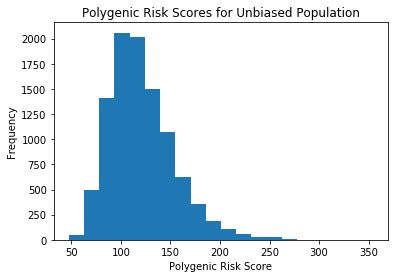

In [8]:
plt.hist(simulated_df['PRS'], bins=20)
plt.title('Polygenic Risk Scores for Unbiased Population')
plt.xlabel('Polygenic Risk Score')
plt.ylabel('Frequency');

**5. Additional Step: Here we will generate a biased data set. We will intentionally give different individuals higher probabilities of having particular SNPs. This will allow us to create low, average, and high risk individuals.**

We begin by modifying step 3 to include such a bias:

In [9]:
# Creating labels that will be associated with disease risk
# 0=Low   1=Mid   2=High
risk_labels = [0, 1, 2]

# Define the probability of being a label
# Low=55%   Mid=30%   High=15%
risk_prob = [.55, .3, .15]

# Defining values to increase probability of having SNP
# Low=0%   Mid=50%   High=100%
risk_bias = [1, 1.5, 2]

indiv_rows_bias = []
indiv_class = []

N = 10000
for _ in range(N):
    label = np.random.choice(a=risk_labels, p=risk_prob)
    bias = risk_bias[label]
    
    has_snps = (maf['Minor Allele Global Frequency']
                .apply(lambda x: np.random.choice(a=[0,1], p=[1-(x*bias), (x*bias)])))
    indiv_rows_bias.append(has_snps.values)
    indiv_class.append(label)
    
    
simulated_bias_df = pd.DataFrame(indiv_rows_bias, columns=maf['Variation ID'])
simulated_bias_df.columns.name = ''
simulated_bias_df.head()

,rs1692580,rs2843152,rs36096196,rs10909862,rs2493298,rs17037390,rs10127456,rs35465346,rs113716316,rs12023377,...,rs944172,rs2140480,rs111245230,rs10981012,rs41311933,rs10818576,rs885150,rs579459,rs495828,rs16999497
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4,1,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


We again calculate the polygenic risk scores.

In [10]:
prs2 = simulated_bias_df.apply(lambda x: (x*beta_values).sum(), axis=1)
simulated_bias_df['PRS'] = prs2
simulated_bias_df.head()

,rs1692580,rs2843152,rs36096196,rs10909862,rs2493298,rs17037390,rs10127456,rs35465346,rs113716316,rs12023377,...,rs2140480,rs111245230,rs10981012,rs41311933,rs10818576,rs885150,rs579459,rs495828,rs16999497,PRS
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,93.619651
1,1,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,139.685852
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,141.302871
3,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,162.675482
4,1,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,143.520535


Let's evaluate the distribution.

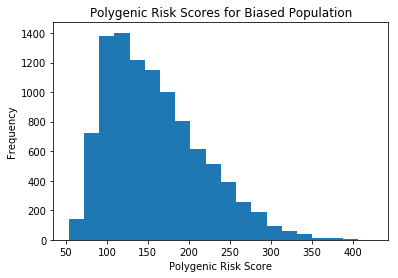

In [11]:
plt.hist(simulated_bias_df['PRS'], bins=20)
plt.title('Polygenic Risk Scores for Biased Population')
plt.xlabel('Polygenic Risk Score')
plt.ylabel('Frequency');

Let's evaluate the assignment of labels.

In [12]:
pd.Series(indiv_class).value_counts(normalize=True)

0    0.5479
1    0.3030
2    0.1491
dtype: float64

Finally, let's see if our biased term worked.

In [13]:
# Adding label to data set
simulated_bias_df['Label'] = indiv_class

# Determining mean polygenic score per label
simulated_bias_df.groupby('Label')['PRS'].mean()

Label
0    121.325489
1    183.022490
2    244.669950
Name: PRS, dtype: float64

C:\Users\micha\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


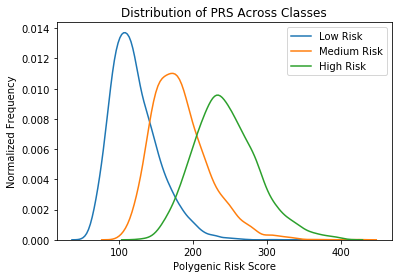

In [14]:
sns.kdeplot(simulated_bias_df[simulated_bias_df['Label'] == 0]['PRS'], label="Low Risk")
sns.kdeplot(simulated_bias_df[simulated_bias_df['Label'] == 1]['PRS'], label="Medium Risk")
sns.kdeplot(simulated_bias_df[simulated_bias_df['Label'] == 2]['PRS'], label="High Risk")
plt.title('Distribution of PRS Across Classes')
plt.xlabel('Polygenic Risk Score')
plt.ylabel('Normalized Frequency');

As can be seen, our bias worked and those with mid and high risks of the disease had higher polygenic risk scores. We hope that we are able to build a model on this labeled data.